In [1]:
#1. IMPORTS AND PATHS
import os, ast
import numpy as np
import pandas as pd
import wfdb

current_dir = os.getcwd()

# Set base folder
DB = os.path.join(current_dir, "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3")
OUT_ROOT = os.path.join(current_dir, "ecg_images")

print(f"Dataset Path: {DB}")
print(f"Output Path: {OUT_ROOT}")

FNAME_COL = "filename_lr" # use low-rate (100 Hz) files
SR = 100                  # sampling rate
TARGET_SIZE = (800, 600)  # output dimensions

os.makedirs(OUT_ROOT, exist_ok=True)

#2. READ METADATA CSVs
df = pd.read_csv(os.path.join(DB, "ptbxl_database.csv"))
scp = pd.read_csv(os.path.join(DB, "scp_statements.csv"), index_col=0)

# Keep only diagnostic statements
diagnostic_codes = scp[scp["diagnostic"] == 1]

#3. MAP SCP CODES TO DIAGNOSTIC SUPERCLASS
def to_superclasses(scp_codes_str):
    codes = ast.literal_eval(scp_codes_str)  # dict: code -> weight
    diags = [c for c in codes.keys() if c in diagnostic_codes.index]
    supers = sorted({diagnostic_codes.loc[c, "diagnostic_class"] for c in diags})
    return supers

df["superclasses"] = df["scp_codes"].apply(to_superclasses)

#4. OFFICIAL STRATIFIED FOLDS
train_df = df[df["strat_fold"].isin(range(1, 9))].copy()
val_df   = df[df["strat_fold"] == 9].copy()
test_df  = df[df["strat_fold"] == 10].copy()

#5. SINGLE-LABEL PRIMARY CLASS PER RECORD
PRIORITY = ["MI", "STTC", "HYP", "CD", "NORM"]

def choose_primary_superclass(superclasses):
    if not superclasses:
        return None
    for c in PRIORITY:
        if c in superclasses:
            return c
    return superclasses[0]

# Apply primary class logic
for split in (train_df, val_df, test_df):
    split["primary_class"] = split["superclasses"].apply(choose_primary_superclass)

# Drop rows with no primary class 
train_df = train_df.dropna(subset=["primary_class"])
val_df   = val_df.dropna(subset=["primary_class"])
test_df  = test_df.dropna(subset=["primary_class"])

print("Setup Complete. Dataframes are ready.")

Dataset Path: /home/user/21012125/Capstone2/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3
Output Path: /home/user/21012125/Capstone2/ecg_images
Setup Complete. Dataframes are ready.


In [2]:
import os
import wfdb
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("Agg") 
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.ticker as ticker
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

# --- 1. MEMORY-SAFE WORKER FUNCTION ---
def process_single_ecg_safe(row, db_path, out_root, fname_col="filename_lr"):
    # Imports inside to ensure isolation
    import os
    import wfdb
    import numpy as np
    from matplotlib.figure import Figure
    from matplotlib.backends.backend_agg import FigureCanvasAgg
    import matplotlib.ticker as ticker

    label = row["primary_class"]
    if not label: return
    
    ecg_id = str(int(row["ecg_id"]))
    out_path = os.path.join(out_root, label, f"{ecg_id}.jpg")
    
    if os.path.exists(out_path): return 

    try:
        # Load Signal
        record_name = row[fname_col]
        full_path = os.path.join(db_path, record_name)
        signals, fields = wfdb.rdsamp(full_path)
        
        # --- PURE OBJECT-ORIENTED PLOTTING ---
        fig = Figure(figsize=(16, 12), dpi=50)
        canvas = FigureCanvasAgg(fig) 
        
        leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        grid_color_major = '#ff5c5c'
        grid_color_minor = '#ff9999'

        for i in range(12):
            ax = fig.add_subplot(4, 3, i + 1)
            sig = signals[:, i]
            t = np.arange(len(sig)) / 100.0
            
            # Plot
            ax.plot(t, sig, color='black', linewidth=1.2)
            
            # Grid
            ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
            ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
            ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
            ax.grid(which='major', linestyle='-', linewidth=0.8, color=grid_color_major, alpha=0.8)
            ax.grid(which='minor', linestyle=':', linewidth=0.5, color=grid_color_minor, alpha=0.5)
            
            # Limits
            ax.set_ylim(-3, 3)
            ax.set_xlim(0, 10)
            
            # Clean axes
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.tick_params(axis='both', which='both', length=0)
            
            # Title
            name = leads[i] if i < 12 else ""
            ax.set_title(name, x=0.02, y=0.8, loc='left', fontsize=12, fontweight='bold', color='blue')

        # Use tight_layout() instead of bbox_inches='tight' (Much Faster)
        fig.tight_layout()
        
        # SAVE FAST: bbox_inches param is GONE
        fig.savefig(out_path, dpi=50, format='jpg')
        
        # Explicit cleanup
        del fig
        del canvas
        
    except Exception as e:
        pass

# --- 2. MANAGER FUNCTION ---
def run_stable_export(df, split_name):
    target_dir = os.path.join(OUT_ROOT, split_name)
    for cls in ["NORM", "MI", "STTC", "HYP", "CD"]:
        os.makedirs(os.path.join(target_dir, cls), exist_ok=True)
        
    rows = [row for _, row in df.iterrows()]
    
    # Use 12 cores (Sweet spot for 16-core machine)
    num_cores = 46 
    print(f"Exporting {split_name} (Fast Mode) using {num_cores} cores...")
    
    Parallel(n_jobs=num_cores, backend="loky")(
        delayed(process_single_ecg_safe)(r, DB, target_dir) for r in tqdm(rows)
    )

# --- 3. RUN IT ---
# if __name__ == "__main__":
#     run_stable_export(train_df, "train")
#     run_stable_export(val_df, "val")
#     run_stable_export(test_df, "test")

In [3]:
#8 COMPUTE CLASS WEIGHTS 
CLASS_ORDER = ["NORM", "MI", "STTC", "HYP", "CD"]  # same order as model output

from collections import Counter
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

#compute pos weight from train only
pos_counts = Counter()
total_train = len(train_df)

for supers in train_df["superclasses"]:
    s = set(supers)
    for cls in CLASS_ORDER:
        if cls in s:
            pos_counts[cls] += 1

# PyTorch expects per-class pos_weight = N_neg / N_pos
pos_weight_np = []
for cls in CLASS_ORDER:
    p = max(1, pos_counts[cls])  # avoid divide-by-zero
    n = total_train - p
    pos_weight_np.append(n / p)

#manually boosting weights for "HYP" because it is performing poorly (0.49)
# print(f"Original HYP weight: {pos_weight_np[3]:.2f}")
# pos_weight_np[3] *= 2  # Increase penalty for missing HYP 
# print(f"Boosted HYP weight:  {pos_weight_np[3]:.2f}")

pos_weight = torch.tensor(pos_weight_np, dtype=torch.float32).to(device)
print("pos_weight (train-only):", dict(zip(CLASS_ORDER, [float(x) for x in pos_weight_np])))

example_weights = []
for supers in train_df["superclasses"]:
    labels = [cls for cls in CLASS_ORDER if cls in supers]
    if not labels:
        w = 1.0
    else:
        w = float(np.mean([pos_weight_np[CLASS_ORDER.index(cls)] for cls in labels]))
    example_weights.append(w)

from torch.utils.data import WeightedRandomSampler
train_sampler = WeightedRandomSampler(
    weights=torch.tensor(example_weights, dtype=torch.double),
    num_samples=len(example_weights),
    replacement=True,
)

pos_weight (train-only): {'NORM': 1.2490784623486044, 'MI': 2.9013473395752456, 'STTC': 3.0812231247013857, 'HYP': 7.062293534686173, 'CD': 3.372664448425902}


In [4]:
import os, json
import pandas as pd

CLASS_ORDER = ["NORM", "MI", "STTC", "HYP", "CD"]

def to_multihot(superclasses):
    s = set(superclasses)
    return {c: int(c in s) for c in CLASS_ORDER}

def build_labels_csv_from_existing(split_df, split_name, out_root=OUT_ROOT):
    """
    create scvs with multihots corresponding to each ecg image, this data should be ready
    to be passed as "tensors" into the neural network

    """

    # empty rows to store all entries
    rows = []
    # the directory of the split (train/val/test)
    split_dir = os.path.join(out_root, split_name)
    # for each entry in the dataframe [id, name, superclass, primaryclass]
    for _, r in split_df.iterrows():
        # we get the super class
        supers = r["superclasses"]          # e.g., ['CD','HYP']
        # supers = NORM
        # if no superclass, then this entry is meaningless
        if not supers:
            continue
        # get primary class
        
        primary = r["primary_class"]
        # get the id of the ecg
        ecg_id = int(r["ecg_id"])
        # find the image that we saved that corresponds to the entry we're lookniga t right now
        # train / NORM / 1.png
        img_path = os.path.join(split_dir, primary, f"{ecg_id}.jpg")
        if not os.path.exists(img_path):
            # might not exist if you used a small 'limit' during export
            continue
        # creates a multihot row
        mh = to_multihot(supers)
        row = {
            "image_path": img_path.replace("\\", "/"),
            "labels": json.dumps(sorted(supers))
        }   
        # add the columns
        row.update(mh)                      # add NORM/MI/STTC/HYP/CD columns
        # add the rows
        rows.append(row)
        # we're essentially building a dataframe that has [imagepath, superclass, [superclasses_multihot]]

    df_out = pd.DataFrame(rows)
    out_csv = os.path.join(out_root, f"{split_name}_labels.csv")
    df_out.to_csv(out_csv, index=False)
    print(f"Wrote {len(df_out)} rows → {out_csv}")
    return out_csv

# build csvs for all splits
train_csv = build_labels_csv_from_existing(train_df, "train")
val_csv   = build_labels_csv_from_existing(val_df,   "val")
test_csv  = build_labels_csv_from_existing(test_df,  "test")

Wrote 17084 rows → /home/user/21012125/Capstone2/ecg_images/train_labels.csv
Wrote 2146 rows → /home/user/21012125/Capstone2/ecg_images/val_labels.csv
Wrote 2158 rows → /home/user/21012125/Capstone2/ecg_images/test_labels.csv


In [5]:
import os, json
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, models

from sklearn.metrics import f1_score, precision_recall_fscore_support, roc_auc_score

OUT_ROOT = os.path.join(current_dir, "ecg_images")
train_csv = os.path.join(OUT_ROOT, "train_labels.csv")
val_csv   = os.path.join(OUT_ROOT, "val_labels.csv")
test_csv  = os.path.join(OUT_ROOT, "test_labels.csv")

# Class order used everywhere
CLASS_ORDER = ["NORM", "MI", "STTC", "HYP", "CD"]

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [6]:
# Transforms & DataLoaders 
IMG_SIZE = 512  # increased to 512 to capture exact height of spikes
IMG_H = 512
IMG_W = 512
from torchvision import transforms as T  # unify alias as T
from ecg_utils import MultiLabelECGImages

# Train transforms:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_H, IMG_W)),
    
    # CHANGED: Added TrivialAugmentWide.
    transforms.TrivialAugmentWide(),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.15)), 
])


# Validation transforms: deterministic (no random augments)
val_transforms = T.Compose([
    T.Resize((IMG_H, IMG_W)),  # match train size / your model input
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225]),
])

# Test/eval transforms: same as validation
eval_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225]),
])

# Datasets
train_ds = MultiLabelECGImages(train_csv, transform=train_transforms)
val_ds   = MultiLabelECGImages(val_csv,   transform=val_transforms)
test_ds  = MultiLabelECGImages(test_csv,  transform=eval_transforms)

# DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 8 

# Use the balanced sampler if you created 'train_sampler' earlier.
# If you did NOT create it, set sampler=None and use shuffle=True.
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,        # <- FIXED name
    sampler=train_sampler,        # <- requires you defined train_sampler; else replace with shuffle=True
    # shuffle=True,               # (use this instead of sampler if you don't have train_sampler)
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

val_dl  = DataLoader(val_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(len(train_ds), len(val_ds), len(test_ds))


17084 2146 2158


In [7]:
import torch.cuda.amp as amp

# Create the scaler 
scaler = amp.GradScaler(enabled=(device.type == "cuda"))

def run_epoch(model, loader, optimizer=None, scheduler=None):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()

    total_loss = 0.0
    all_targets, all_probs = [], []

    # Iterate over batches
    for imgs, targets in loader:
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if train_mode:
            optimizer.zero_grad(set_to_none=True) # Slightly faster than zero_grad()

        # --- SPEEDUP FIX: Use Automatic Mixed Precision (AMP) ---
        with torch.amp.autocast(device_type='cuda', enabled=(device.type == "cuda")):
            logits = model(imgs)
            loss = loss_function(logits, targets)

        if train_mode:
            # Use scaler to handle the lower precision math
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            if scheduler is not None:
                scheduler.step()

        total_loss += loss.item() * imgs.size(0)

        # Save predictions (move to CPU to save GPU RAM)
        with torch.no_grad():
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            all_targets.append(targets.detach().cpu().numpy())
            all_probs.append(probs)

    # Combine all batches
    all_targets = np.concatenate(all_targets, axis=0)
    all_probs = np.concatenate(all_probs, axis=0)
    avg_loss = total_loss / len(loader.dataset)

    return avg_loss, all_targets, all_probs

def multilabel_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    # Per-class precision/recall/F1
    # prec, rec, f1, support (no. occurences of each label in y_true)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)
    macro_f1 = f1.mean()
    micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
    # AUROC per class (guard against classes with single label value)
    
    aurocs = []
    for i in range(y_true.shape[1]):
        if len(np.unique(y_true[:, i])) == 2:
            aurocs.append(roc_auc_score(y_true[:, i], y_prob[:, i]))
        else:
            aurocs.append(float('nan'))
    return {
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "per_class_f1": dict(zip(CLASS_ORDER, f1)),
        "per_class_precision": dict(zip(CLASS_ORDER, prec)),
        "per_class_recall": dict(zip(CLASS_ORDER, rec)),
        "per_class_auroc": dict(zip(CLASS_ORDER, aurocs)),
    }

/tmp/ipykernel_31500/3015308536.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler(enabled=(device.type == "cuda"))


In [8]:
# ===== Model & Loss =====
import copy
import matplotlib.pyplot as plt # Ensure we have this for plotting

class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_pos=0.0, gamma_neg=4.0, clip=0.05, eps=1e-8):
        super().__init__()
        self.gamma_pos, self.gamma_neg, self.clip, self.eps = gamma_pos, gamma_neg, clip, eps

    def forward(self, logits, targets):
        x_sig = torch.sigmoid(logits)
        if self.clip and self.clip > 0:
            x_sig = torch.clamp(x_sig, self.clip, 1.0 - self.clip)
        xs_pos = x_sig
        xs_neg = 1.0 - x_sig
        w = (1 - xs_pos) ** self.gamma_pos * targets + (1 - xs_neg) ** self.gamma_neg * (1 - targets)
        loss = - (targets * torch.log(xs_pos + self.eps) + (1 - targets) * torch.log(xs_neg + self.eps))
        return (w * loss).mean()

loss_function = AsymmetricLoss(gamma_pos=0.0, gamma_neg=4.0, clip=0.05)

# # ===== ResNet34 Backbone =====
from torchvision import models

# # backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  #restnet50 was too big, switching to resnet34
# backbone = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
 
# in_features = backbone.fc.in_features
# backbone.fc = nn.Sequential(
#     nn.Dropout(p=0.5),
#     nn.Linear(in_features, len(CLASS_ORDER))
# )
# model = backbone.to(device)


# ===== DenseNet121 Backbone ===== 
backbone = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

in_features = backbone.classifier.in_features
backbone.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, len(CLASS_ORDER))
)

model = backbone.to(device)

# ===== Training setup: 2-phase (warmup + fine-tune) =====
WARMUP_EPOCHS = 5
TOTAL_EPOCHS  = 20

# Lists to store loss history for plotting 
train_losses = []
val_losses = []

# ---------- PHASE 1: freeze backbone, train only the head ----------
for name, p in model.named_parameters():
    if name.startswith("classifier."):     # final FC layer of ResNet18
        p.requires_grad = True
    else:
        p.requires_grad = False    # backbone frozen

# Only head params will be trainable
trainable_params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.AdamW(
    trainable_params,
    lr=3e-4,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-4,
    steps_per_epoch=len(train_dl),
    epochs=WARMUP_EPOCHS,
    pct_start=0.1,
    anneal_strategy="cos",
    div_factor=10.0,
    final_div_factor=10.0,
)

best_val_macro = 0.0
best_state_dict = None

for epoch in range(1, WARMUP_EPOCHS + 1):
    print(f"\n[Warmup] Epoch {epoch}/{WARMUP_EPOCHS}")

    # IMPORTANT: pass scheduler into run_epoch so it can step per batch
    train_loss, y_true_tr, y_prob_tr = run_epoch(model, train_dl, optimizer, scheduler)
    val_loss, y_true_val, y_prob_val = run_epoch(model, val_dl, optimizer=None)
    
    #  Save history
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    metrics_val = multilabel_metrics(y_true_val, y_prob_val, threshold=0.5)
    macro_f1_val  = metrics_val["macro_f1"]
    micro_f1_val  = metrics_val["micro_f1"]
    per_class_au  = metrics_val["per_class_auroc"]  # this is a dict by class
    
    print(f"Val macro-F1: {macro_f1_val:.4f}")
    print(f"Val micro-F1: {micro_f1_val:.4f}")

    if macro_f1_val > best_val_macro:
        best_val_macro = macro_f1_val
        best_state_dict = copy.deepcopy(model.state_dict())


# ---------- PHASE 2: unfreeze and fine-tune entire network ----------
for p in model.parameters():
    p.requires_grad = True

backbone_params = []
head_params = []
for name, p in model.named_parameters():
    if not p.requires_grad:
        continue
    if name.startswith("classifier."):
        head_params.append(p)       # final classifier layer
    else:
        backbone_params.append(p)   # pretrained conv backbone

optimizer = torch.optim.AdamW(
    [
        {"params": backbone_params, "lr": 5e-5, "weight_decay": 0.01},  # smaller LR
        {"params": head_params,     "lr": 1e-4, "weight_decay": 0.01},  # larger LR
    ]
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,      
    T_mult=1,
    eta_min=1e-6
)

for epoch in range(WARMUP_EPOCHS + 1, TOTAL_EPOCHS + 1):
    print(f"\n[Fine-tune] Epoch {epoch}/{TOTAL_EPOCHS}")

    train_loss, y_true_tr, y_prob_tr = run_epoch(model, train_dl, optimizer, scheduler)
    val_loss, y_true_val, y_prob_val = run_epoch(model, val_dl, optimizer=None)
    
    # ### NEW CODE: Save history ###
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    metrics_val = multilabel_metrics(y_true_val, y_prob_val, threshold=0.5)
    macro_f1_val  = metrics_val["macro_f1"]
    micro_f1_val  = metrics_val["micro_f1"]
    per_class_au  = metrics_val["per_class_auroc"]  # this is a dict by class
    
    print(f"Val macro-F1: {macro_f1_val:.4f}")
    print(f"Val micro-F1: {micro_f1_val:.4f}")

    if macro_f1_val > best_val_macro:
        best_val_macro = macro_f1_val
        best_state_dict = copy.deepcopy(model.state_dict())

# After training: restore best weights before doing VAL threshold search / TEST
model.load_state_dict(best_state_dict)

#save to disk
save_path = os.path.join(OUT_ROOT, "best_model_densenet121.pth")
torch.save(model.state_dict(), save_path)
print(f"Saved model to: {save_path}")

# Plotting the graph
print("\nGenerating Loss Graph...")
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(val_losses, label='Validation Loss', color='orange', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the plot to the output folder
graph_path = os.path.join(OUT_ROOT, "loss_graph.png")
plt.savefig(graph_path)
print(f"Graph saved to: {graph_path}")
print("Please open this file in your file browser to view the graph.")


[Warmup] Epoch 1/5
Val macro-F1: 0.4682
Val micro-F1: 0.4809

[Warmup] Epoch 2/5
Val macro-F1: 0.4679
Val micro-F1: 0.4787

[Warmup] Epoch 3/5
Val macro-F1: 0.4744
Val micro-F1: 0.4812

[Warmup] Epoch 4/5
Val macro-F1: 0.4776
Val micro-F1: 0.4901

[Warmup] Epoch 5/5
Val macro-F1: 0.4774
Val micro-F1: 0.4899

[Fine-tune] Epoch 6/20
Val macro-F1: 0.6543
Val micro-F1: 0.6777

[Fine-tune] Epoch 7/20
Val macro-F1: 0.6664
Val micro-F1: 0.6918

[Fine-tune] Epoch 8/20
Val macro-F1: 0.6826
Val micro-F1: 0.7079

[Fine-tune] Epoch 9/20
Val macro-F1: 0.7005
Val micro-F1: 0.7282

[Fine-tune] Epoch 10/20
Val macro-F1: 0.7119
Val micro-F1: 0.7390

[Fine-tune] Epoch 11/20
Val macro-F1: 0.7034
Val micro-F1: 0.7303

[Fine-tune] Epoch 12/20
Val macro-F1: 0.7105
Val micro-F1: 0.7386

[Fine-tune] Epoch 13/20
Val macro-F1: 0.7106
Val micro-F1: 0.7388

[Fine-tune] Epoch 14/20
Val macro-F1: 0.7107
Val micro-F1: 0.7368

[Fine-tune] Epoch 15/20
Val macro-F1: 0.7120
Val micro-F1: 0.7382

[Fine-tune] Epoch 16/20

In [ ]:
# RELOAD SAVED MODEL (SKIP TRAINING)
# Run this cell to skip training and load best model
# --- RE-DEFINE MODEL ARCHITECTURE (No Training) ---
import torch.nn as nn
from torchvision import models

# 1. Define DenseNet121 exactly as you did in training
backbone = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

in_features = backbone.classifier.in_features
backbone.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, len(CLASS_ORDER))
)

model = backbone.to(device)
print("Model structure re-created.")


model_path = os.path.join(OUT_ROOT, "best_model_densenet121.pth")

if os.path.exists(model_path):
    print(f"Found saved model at {model_path}. Loading...")
    
    # 1. Re-initialize the empty model structure 
    # (Since we ran Model Definition earlier, 'model' variable already exists)
    
    # 2. Load the weights from the file
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    
    model.to(device)
    model.eval() # Set to evaluation mode
    print("Model loaded successfully! Ready for diagnosis/testing.")
else:
    print("No saved model found. You must run the training cell first.")

In [ ]:
# pip install opencv-python

Searching for high-confidence examples for: ['NORM', 'MI', 'STTC', 'HYP', 'CD']...
Found match for NORM! Confidence: 0.98


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].


Saved gradcam_NORM.png
Found match for STTC! Confidence: 0.81


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009157627820968628..1.0000000238418578].


Saved gradcam_STTC.png
Found match for CD! Confidence: 0.93
Saved gradcam_CD.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].


Found match for MI! Confidence: 1.00
Saved gradcam_MI.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].


Found match for HYP! Confidence: 0.79
Saved gradcam_HYP.png
Done!


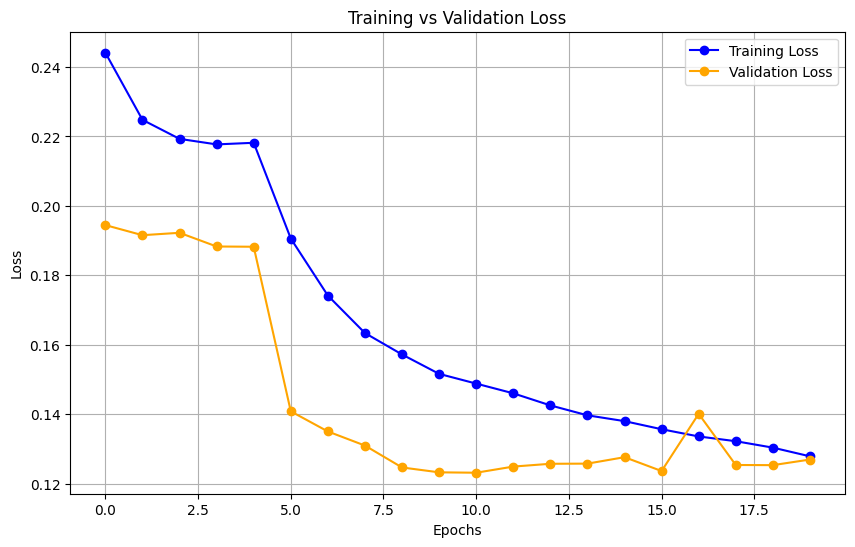

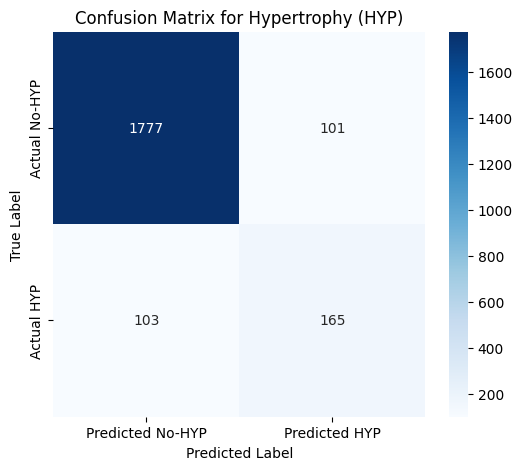

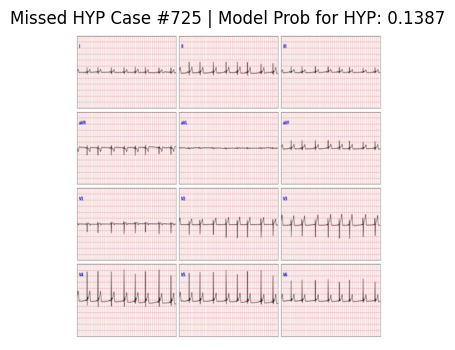

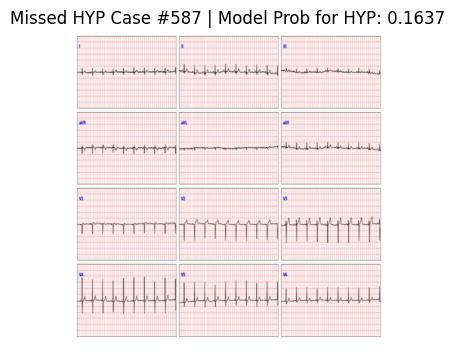

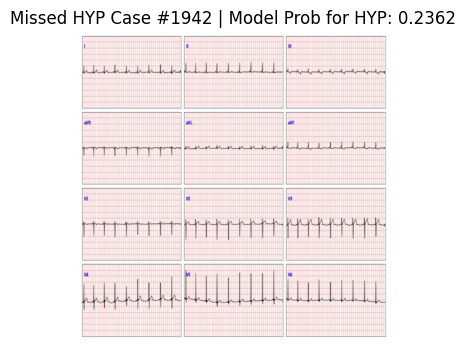

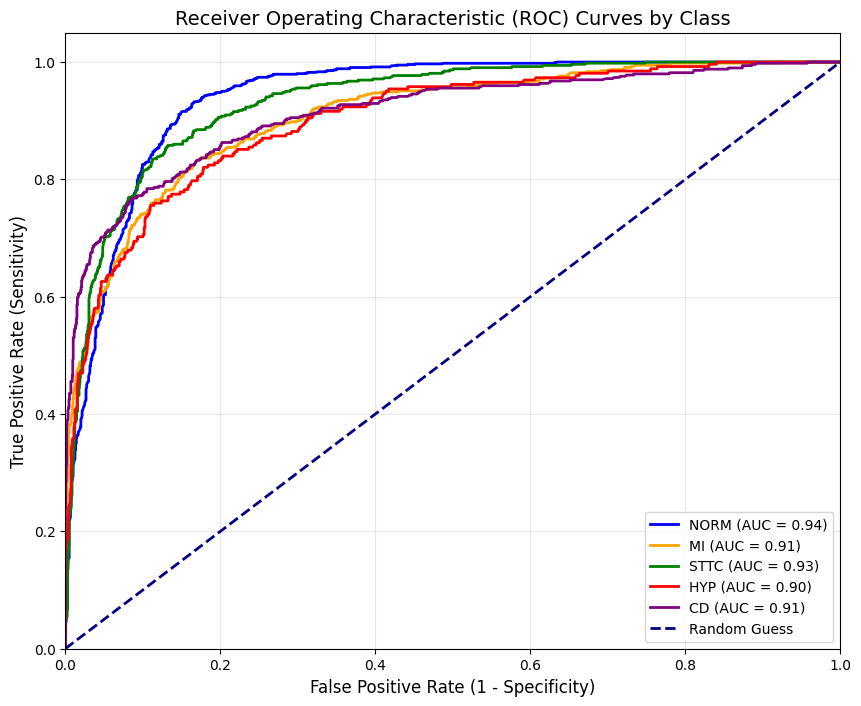

In [19]:
#GRAD CAM

%matplotlib inline 
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import os

# Ensure output directory
OUT_ROOT = "ecg_images"
os.makedirs(OUT_ROOT, exist_ok=True)

# --- 1. Define Grad-CAM (Standard) ---
def compute_gradcam(model, img_tensor, target_class_idx=None):
    model.eval()
    device = next(model.parameters()).device
    img_tensor = img_tensor.to(device)
    if img_tensor.dim() == 3: img_tensor = img_tensor.unsqueeze(0) 

    features = model.features(img_tensor)
    features.retain_grad()
    
    out = torch.nn.functional.relu(features, inplace=False)
    out = torch.nn.functional.adaptive_avg_pool2d(out, (1, 1))
    out = torch.flatten(out, 1)
    logits = model.classifier(out)
    
    model.zero_grad()
    if target_class_idx is None: target_class_idx = logits.argmax(dim=1).item()
    score = logits[0, target_class_idx]
    score.backward()
    
    gradients = features.grad[0].cpu().data.numpy()
    fmaps = features[0].cpu().data.numpy()
    weights = np.mean(gradients, axis=(1, 2))
    cam = np.zeros(fmaps.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights): cam += w * fmaps[i]
        
    cam = np.maximum(cam, 0)
    if np.max(cam) > 0: cam = cam / np.max(cam)
    cam = cv2.resize(cam, (512, 512))
    return cam, target_class_idx, torch.sigmoid(logits).detach().cpu().numpy()[0]

# --- 2. SEARCH AND SAVE FOR ALL 5 CLASSES ---
# We need to iterate through the entire validation loader to find examples
data_iterator = iter(val_dl)
classes_found = []
target_classes = ['NORM', 'MI', 'STTC', 'HYP', 'CD']

print(f"Searching for high-confidence examples for: {target_classes}...")

try:
    # Loop through batches
    while len(classes_found) < 5:
        images, labels = next(data_iterator)
        
        for i in range(len(images)):
            # Run simple inference
            input_tensor = images[i].unsqueeze(0).to(device)
            logits = model(input_tensor)
            probs = torch.sigmoid(logits).detach().cpu().numpy()[0]
            
            pred_idx = np.argmax(probs)
            true_idx = np.argmax(labels[i].numpy())
            pred_class_name = CLASS_ORDER[pred_idx]
            
            # Check: 
            # 1. Correct Prediction
            # 2. High Confidence (> 0.75)
            # 3. We haven't found this class yet
            if (pred_idx == true_idx) and (probs[pred_idx] > 0.75) and (pred_class_name not in classes_found):
                
                print(f"Found match for {pred_class_name}! Confidence: {probs[pred_idx]:.2f}")
                
                # Generate Grad-CAM
                heatmap, _, _ = compute_gradcam(model, images[i], target_class_idx=pred_idx)
                
                # Visualize
                img_plot = images[i].permute(1, 2, 0).cpu().numpy()
                img_plot = (img_plot - img_plot.min()) / (img_plot.max() - img_plot.min())
                
                heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
                heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
                
                superimposed = heatmap_colored * 0.4 + img_plot * 0.6
                
                # Plot
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(img_plot)
                plt.title(f"Original ECG\nTrue: {pred_class_name}")
                plt.axis('off')
                
                plt.subplot(1, 3, 2)
                plt.imshow(heatmap, cmap='jet')
                plt.title(f"Grad-CAM {pred_class_name}")
                plt.axis('off')
                
                plt.subplot(1, 3, 3)
                plt.imshow(superimposed)
                plt.title(f"Overlay\nConfidence: {probs[pred_idx]:.2f}")
                plt.axis('off')
                
                # Save
                filename = f"gradcam_{pred_class_name}.png"
                plt.savefig(os.path.join(OUT_ROOT, filename))
                print(f"Saved {filename}")
                plt.close() # Close figure to save memory
                
                classes_found.append(pred_class_name)
                
                if len(classes_found) == 5:
                    break
                    
except StopIteration:
    print("Reached end of validation set.")
    print(f"Found examples for: {classes_found}")
    print(f"Could not find high-confidence examples for: {list(set(target_classes) - set(classes_found))}")

print("Done!")

In [9]:
train_loss_best, y_true_tr_best, y_prob_tr_best = run_epoch(model, train_dl, optimizer=None)
val_loss_best,   y_true_val_best, y_prob_val_best = run_epoch(model, val_dl, optimizer=None)

metrics_train = multilabel_metrics(y_true_tr_best, y_prob_tr_best, threshold=0.5)
metrics_val   = multilabel_metrics(y_true_val_best, y_prob_val_best, threshold=0.5)

print("Train macro-F1:", metrics_train["macro_f1"])
print("Val   macro-F1:", metrics_val["macro_f1"])
print("Val   micro-F1:", metrics_val["micro_f1"])

Train macro-F1: 0.7454099163447864
Val   macro-F1: 0.7312577600183767
Val   micro-F1: 0.7581343163968585


In [10]:
from sklearn.metrics import f1_score, precision_recall_fscore_support
import numpy as np

from sklearn.metrics import precision_recall_curve

def best_thresholds_per_class(y_true_val, y_prob_val):
    C = y_true_val.shape[1]
    best_thresholds = np.full(C, 0.5, dtype=np.float32)
    
    for c in range(C):
        yt, yp = y_true_val[:, c], y_prob_val[:, c]
        
        # Skip if constant (all 0s or all 1s)
        if len(np.unique(yt)) < 2:
            continue
            
        # Get all possible thresholds from the curve
        precisions, recalls, thresholds = precision_recall_curve(yt, yp)
        
        # Calculate F1 for every single possible threshold
        # F1 = 2 * (P * R) / (P + R)
        with np.errstate(divide='ignore', invalid='ignore'):
            f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
            f1_scores = np.nan_to_num(f1_scores) # Handle division by zero
        
        # Find index of the highest F1 score
        best_idx = np.argmax(f1_scores)
        
        # precision_recall_curve returns thresholds with length = len(precisions) - 1
        # The last precision/recall value is always 1.0/0.0, which has no corresponding threshold index
        if best_idx < len(thresholds):
            best_thresholds[c] = thresholds[best_idx]
        else:
            best_thresholds[c] = 0.5 # Fallback if edge case
            
    return best_thresholds

# ---- VAL: find best threshold per class ----
val_loss, y_true_val, y_prob_val = run_epoch(model, val_dl, optimizer=None)
per_class_thr = best_thresholds_per_class(y_true_val, y_prob_val)
print("Per-class thresholds (VAL, CLASS_ORDER):", dict(zip(CLASS_ORDER, per_class_thr)))

# ---- TEST: evaluate with base 0.5 threshold ----
test_loss, y_true_test, y_prob_test = run_epoch(model, test_dl, optimizer=None)

metrics_test = multilabel_metrics(y_true_test, y_prob_test, threshold=0.5)
macro_f1_05  = metrics_test["macro_f1"]
micro_f1_05  = metrics_test["micro_f1"]

print(f"\n[Test @ 0.5] Macro-F1: {macro_f1_05:.4f}")
print(f"[Test @ 0.5] Micro-F1: {micro_f1_05:.4f}")
print("Per-class F1 @ 0.5:", metrics_test["per_class_f1"])
print("Per-class AUROC:", metrics_test["per_class_auroc"])

# ---- TEST: evaluate with tuned thresholds from VAL ----
# per_class_thr is already aligned with CLASS_ORDER, same as y_prob_test columns
y_pred_test_tuned = (y_prob_test >= per_class_thr[None, :]).astype(int)

prec, rec, f1, _ = precision_recall_fscore_support(
    y_true_test, y_pred_test_tuned, average=None, zero_division=0
)

per_class_f1_tuned = dict(zip(CLASS_ORDER, f1))
macro_f1_tuned = float(np.mean(f1))

print(f"\n[Test @ tuned thresholds] Macro-F1 (tuned): {macro_f1_tuned:.4f}")
print("Per-class F1 (tuned):", per_class_f1_tuned)
print("Per-class thresholds (CLASS_ORDER):", dict(zip(CLASS_ORDER, per_class_thr)))


Per-class thresholds (VAL, CLASS_ORDER): {'NORM': np.float32(0.67578125), 'MI': np.float32(0.54052734), 'STTC': np.float32(0.56884766), 'HYP': np.float32(0.6064453), 'CD': np.float32(0.55615234)}

[Test @ 0.5] Macro-F1: 0.7256
[Test @ 0.5] Micro-F1: 0.7552
Per-class F1 @ 0.5: {'NORM': np.float64(0.8328187031318923), 'MI': np.float64(0.7269338303821062), 'STTC': np.float64(0.7386644682605111), 'HYP': np.float64(0.5875370919881305), 'CD': np.float64(0.7420349434737924)}
Per-class AUROC: {'NORM': 0.9408847004436103, 'MI': 0.9074310266847581, 'STTC': 0.9331327964055778, 'HYP': 0.9007985876252134, 'CD': 0.912627736695004}

[Test @ tuned thresholds] Macro-F1 (tuned): 0.7454
Per-class F1 (tuned): {'NORM': np.float64(0.8713450292397661), 'MI': np.float64(0.7131630648330058), 'STTC': np.float64(0.7593097184377838), 'HYP': np.float64(0.6283524904214559), 'CD': np.float64(0.7546754675467546)}
Per-class thresholds (CLASS_ORDER): {'NORM': np.float32(0.67578125), 'MI': np.float32(0.54052734), 'STTC'

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

"""
FINE tuning:
0. epochs
1. dropout
2. lr
3. weight decay
4. factor (scheduler)
6. patience (scheduler)
7. more feature classes in ConvBlock
8. more layers for convblock
9. image augmentation
10. increase data size, increase image resolution, change to higher bitrate
"""

# Extra metrics at 0.5 threshold 
threshold = 0.5
y_pred_test_05 = (y_prob_test >= threshold).astype(int)
exact_match = np.all(y_pred_test_05 == y_true_test, axis=1)
exact_acc = exact_match.mean() * 100
labelwise_acc = (y_pred_test_05 == y_true_test).mean() * 100

print(f"\nExact-match accuracy @ 0.5: {exact_acc:.2f}%")
print(f"Label-wise mean accuracy @ 0.5: {labelwise_acc:.2f}%")


Exact-match accuracy @ 0.5: 52.18%
Label-wise mean accuracy @ 0.5: 85.93%


In [12]:
threshold = 0.5
y_pred_val_05 = (y_prob_val >= threshold).astype(int)

# Exact-match: all labels for a sample must be correct
exact_match_val = np.all(y_pred_val_05 == y_true_val, axis=1)
exact_acc_val = exact_match_val.mean() * 100

# Label-wise mean accuracy: average over all label positions
labelwise_acc_val = (y_pred_val_05 == y_true_val).mean() * 100

print(f"\n[VAL @ 0.5] Exact-match accuracy: {exact_acc_val:.2f}%")
print(f"[VAL @ 0.5] Label-wise mean accuracy: {labelwise_acc_val:.2f}%")



[VAL @ 0.5] Exact-match accuracy: 52.00%
[VAL @ 0.5] Label-wise mean accuracy: 85.94%


In [13]:
# After compute test_loss, y_true_test, y_prob_test
metrics_test_05 = multilabel_metrics(y_true_test, y_prob_test, threshold=0.5)
print("=== Test @ threshold=0.5 ===")
print("MacroF1:", metrics_test_05["macro_f1"])
print("Per-class F1:", metrics_test_05["per_class_f1"])


=== Test @ threshold=0.5 ===
MacroF1: 0.7255978074472865
Per-class F1: {'NORM': np.float64(0.8328187031318923), 'MI': np.float64(0.7269338303821062), 'STTC': np.float64(0.7386644682605111), 'HYP': np.float64(0.5875370919881305), 'CD': np.float64(0.7420349434737924)}


In [14]:
val_support = y_true_val.sum(axis=0)
test_support = y_true_test.sum(axis=0)
print("VAL positives:", dict(zip(CLASS_ORDER, val_support)))
print("TEST positives:", dict(zip(CLASS_ORDER, test_support)))


VAL positives: {'NORM': np.float32(955.0), 'MI': np.float32(540.0), 'STTC': np.float32(528.0), 'HYP': np.float32(268.0), 'CD': np.float32(495.0)}
TEST positives: {'NORM': np.float32(963.0), 'MI': np.float32(550.0), 'STTC': np.float32(521.0), 'HYP': np.float32(262.0), 'CD': np.float32(496.0)}


In [15]:
def best_global_threshold(y_true, y_prob, grid=np.linspace(0.1, 0.9, 17)):
    best_t, best_f1 = 0.5, -1
    for t in grid:
        f1 = f1_score(y_true, (y_prob >= t).astype(int), average="macro", zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

t_global, f1_global_val = best_global_threshold(y_true_val, y_prob_val)
print("Best global t on VAL:", t_global, "macroF1:", f1_global_val)

y_pred_test_global = (y_prob_test >= t_global).astype(int)
_, _, f1_test_global, _ = precision_recall_fscore_support(
    y_true_test, y_pred_test_global, average=None, zero_division=0
)
print("MacroF1 TEST @ global t:", float(f1_test_global.mean()))
print("Per-class F1 TEST @ global t:", dict(zip(CLASS_ORDER, f1_test_global)))


Best global t on VAL: 0.55 macroF1: 0.7400889006440338
MacroF1 TEST @ global t: 0.7343223806075094
Per-class F1 TEST @ global t: {'NORM': np.float64(0.8477180298237686), 'MI': np.float64(0.709613478691774), 'STTC': np.float64(0.7613941018766756), 'HYP': np.float64(0.5993265993265994), 'CD': np.float64(0.7535596933187295)}


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import torch

def diagnose_hyp_errors(model, loader, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []
    
    print("Collecting predictions for diagnosis...")
    with torch.no_grad():
        for imgs, targets in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits)
            
            all_preds.append(probs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    y_prob = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)
    
    # --- 1. Confusion Matrix for HYP ---
    # HYP is index 3 in CLASS_ORDER = ["NORM", "MI", "STTC", "HYP", "CD"]
    hyp_idx = 3
    hyp_true = y_true[:, hyp_idx]
    hyp_pred = (y_prob[:, hyp_idx] >= threshold).astype(int)
    
    cm = confusion_matrix(hyp_true, hyp_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted No-HYP', 'Predicted HYP'],
                yticklabels=['Actual No-HYP', 'Actual HYP'])
    plt.title('Confusion Matrix for Hypertrophy (HYP)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    # Save the Confusion Matrix
    plt.savefig(os.path.join(OUT_ROOT, "hyp_confusion_matrix.png"))
    plt.show()
    
    # --- 2. Visualize False Negatives (The "Missed" Cases) ---
    # Find indices where True=1 but Pred=0
    fn_indices = np.where((hyp_true == 1) & (hyp_pred == 0))[0]
    
    print(f"Found {len(fn_indices)} HYP cases that were MISSED (False Negatives).")
    print("Showing top 3 with highest confidence in being 'Normal'...")
    
    # Sort by how "wrong" the model was (lowest probability for HYP)
    worst_misses = fn_indices[np.argsort(y_prob[fn_indices, hyp_idx])[:3]]
    
    # We need to fetch images from the dataset wrapper to visualize them
    # Note: We will use the Validation Dataset (val_ds)
    for i, idx in enumerate(worst_misses):
        img_tensor, _ = val_ds[idx] 
        
        # Simple denormalize for visualization (approximate)
        img_disp = img_tensor.permute(1, 2, 0).numpy()
        img_disp = (img_disp * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        img_disp = np.clip(img_disp, 0, 1)
        
        plt.figure(figsize=(10, 4))
        plt.imshow(img_disp)
        plt.title(f"Missed HYP Case #{idx} | Model Prob for HYP: {y_prob[idx, hyp_idx]:.4f}")
        plt.axis('off')
        # Save the missed case image
        plt.savefig(os.path.join(OUT_ROOT, f"missed_hyp_case_{i+1}.png"))
        plt.show()

# Run the function using your validation loader
diagnose_hyp_errors(model, val_dl, threshold=0.6)

Found 103 HYP cases that were MISSED (False Negatives).
Showing top 3 with highest confidence in being 'Normal'...


In [ ]:
#this is to delete images in ecg_images for resetting

# import shutil

# if os.path.exists(OUT_ROOT):
#     shutil.rmtree(OUT_ROOT)
#     print(f"Deleted {OUT_ROOT}. Ready to regenerate.")
# os.makedirs(OUT_ROOT, exist_ok=True)

In [17]:
#this is to get precision recall for all 5 classes for report purpose
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

# Use your tuned thresholds if available, otherwise default to 0.5
# If you ran the threshold tuning cell, 'per_class_thr' variable exists.
# If not, uncomment the line below to use default 0.5
# per_class_thr = np.full(5, 0.5) 

# Generate binary predictions based on thresholds
y_pred_test_tuned = (y_prob_test >= per_class_thr[None, :]).astype(int)

# Calculate metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_true_test, y_pred_test_tuned, average=None, zero_division=0
)

# Create a DataFrame for a nice table view
results_df = pd.DataFrame({
    'Class': CLASS_ORDER,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support (Count)': support
})

print("\n=== Detailed Per-Class Performance (Test Set) ===")
print(results_df.round(4))

# Optional: Print simple list format if you prefer
print("\n[Copy-Paste Format]")
print(f"Per-class Precision: {dict(zip(CLASS_ORDER, np.round(precision, 4)))}")
print(f"Per-class Recall:    {dict(zip(CLASS_ORDER, np.round(recall, 4)))}")


=== Detailed Per-Class Performance (Test Set) ===
  Class  Precision  Recall  F1-Score  Support (Count)
0  NORM     0.8209  0.9283    0.8713              963
1    MI     0.7756  0.6600    0.7132              550
2  STTC     0.7207  0.8023    0.7593              521
3   HYP     0.6308  0.6260    0.6284              262
4    CD     0.8305  0.6915    0.7547              496

[Copy-Paste Format]
Per-class Precision: {'NORM': np.float64(0.8209), 'MI': np.float64(0.7756), 'STTC': np.float64(0.7207), 'HYP': np.float64(0.6308), 'CD': np.float64(0.8305)}
Per-class Recall:    {'NORM': np.float64(0.9283), 'MI': np.float64(0.66), 'STTC': np.float64(0.8023), 'HYP': np.float64(0.626), 'CD': np.float64(0.6915)}


In [18]:
# this is to generate roc graphs for all 5 classes, also for report purpose
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 8))
colors = ['blue', 'orange', 'green', 'red', 'purple'] # Colors for the 5 classes

for i, cls in enumerate(CLASS_ORDER):
    # Calculate False Positive Rate (fpr) and True Positive Rate (tpr)
    fpr, tpr, _ = roc_curve(y_true_test[:, i], y_prob_test[:, i])
    
    # Calculate Area Under Curve (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Plot the curve
    plt.plot(fpr, tpr, color=colors[i], lw=2, 
             label=f'{cls} (AUC = {roc_auc:.2f})')

# Plot the "Random Guess" diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Formatting details for academic report
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curves by Class', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)

# Save the image
save_path = os.path.join(OUT_ROOT, "roc_curves.png")
plt.savefig(save_path, dpi=300)
print(f"ROC Curve graph saved to: {save_path}")
plt.show()

ROC Curve graph saved to: /home/user/21012125/Capstone2/ecg_images/roc_curves.png
